In [1]:
import sys
sys.path.insert(0, "../")

from utils.ptq_utils import get_fid, get_pretrained_model
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
weights_path = "../weights" # path where you placed pretrained weights
tmp_data_dir = "/media/data/fid_data" # path where intermediate data will be stored
generated_data_dir = "/media/data/mlproject" # path where prepare_data.py script generated data

In [3]:
import pandas as pd
df = pd.DataFrame(columns=["method", "quant_bits", "FID", "per_channel", "qFID"])

for method in ["vanilla-ptq","ar-brecq", "lsq-brecq"]:
    for n_bits in [4, 8]:
        for per_channel in [True, False]:
            q_params = {'q_max': 0.9999, 'q_min': 1 - 0.9999,
                        'q_max_w': 0.9999, 'q_min_w': 1 - 0.9999,
                        'bits_w': n_bits, "per_channel":per_channel,
                        'lsq_act': "brecq" in method, 'lsq_weight': method=="lsq-brecq",
                        'adaround': method=="ar-brecq"} 
            
            path = weights_path + f"/{method}_per_channel{per_channel}_n_bits{n_bits}.pth"
            fp_path = weights_path + "/fp_model.pth"
            
            model = get_pretrained_model(path, fp_path, q_params).cuda().eval()
            
            data_dir = tmp_data_dir + f'/method_{method}_bits_{n_bits}_perchannel{per_channel}'     
            qfid = get_fid(model, data_dir, reference_data=generated_data_dir + "/fp_data",
                           use_cache=True, qfid=True)

            fid = get_fid(model, data_dir, reference_data=generated_data_dir + "/real_images",
                           use_cache=True, qfid=False)

            print(f'Method {method}, {n_bits} bits, per_channel={per_channel}')
            print('FID:', fid)
            print('qFID:', qfid)

            df = df.append({"quant_bits":n_bits, "per_channel":per_channel,
                            "FID":fid, "qFID":qfid, "method":method}, ignore_index=True)

Calibrating...: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


Method vanilla-ptq, 4 bits, per_channel=True
FID: 73.08835541078781
qFID: 60.330677757181775


Calibrating...: 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Method vanilla-ptq, 4 bits, per_channel=False
FID: 73.54962454262153
qFID: 62.37487778172601


Calibrating...: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Method vanilla-ptq, 8 bits, per_channel=True
FID: 66.4910323949482
qFID: 51.15387796427581


Calibrating...: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Method vanilla-ptq, 8 bits, per_channel=False
FID: 65.9373709956422
qFID: 50.394473624709576


Calibrating...: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Method ar-brecq, 4 bits, per_channel=True
FID: 61.24727054108507
qFID: 46.20091107679576


Calibrating...: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Method ar-brecq, 4 bits, per_channel=False
FID: 61.85057688670031
qFID: 48.06934793739475


Calibrating...: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Method ar-brecq, 8 bits, per_channel=True
FID: 66.787539008186
qFID: 49.87371385016252


Calibrating...: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Method ar-brecq, 8 bits, per_channel=False
FID: 65.14960147296682
qFID: 48.36684319010823


Calibrating...: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Method lsq-brecq, 4 bits, per_channel=True
FID: 61.0762168803696
qFID: 49.80816326678905


Calibrating...: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Method lsq-brecq, 4 bits, per_channel=False
FID: 69.99778988437617
qFID: 57.89682959875529


Calibrating...: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Method lsq-brecq, 8 bits, per_channel=True
FID: 52.920908320669184
qFID: 37.23183258792733


Calibrating...: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Method lsq-brecq, 8 bits, per_channel=False
FID: 51.658030566517084
qFID: 35.87952809763004


In [4]:
df

,method,quant_bits,FID,per_channel,qFID
0,vanilla-ptq,4,73.088355,True,60.330678
1,vanilla-ptq,4,73.549625,False,62.374878
2,vanilla-ptq,8,66.491032,True,51.153878
3,vanilla-ptq,8,65.937371,False,50.394474
4,ar-brecq,4,61.247271,True,46.200911
5,ar-brecq,4,61.850577,False,48.069348
6,ar-brecq,8,66.787539,True,49.873714
7,ar-brecq,8,65.149601,False,48.366843
8,lsq-brecq,4,61.076217,True,49.808163
9,lsq-brecq,4,69.997790,False,57.896830


In [5]:
from utils.ptq_utils import calculate_fid_given_paths
fp_data = generated_data_dir + "/fp_data/distil_pics"
real_data = generated_data_dir + "/real_images"

fp_data_fid = calculate_fid_given_paths([fp_data, real_data], 32, True, 2048, False)
print("Full precion model FID", fp_data_fid)

/home/pavel/main/lib/python3.7/site-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


Full precion model FID 26.260431468646857


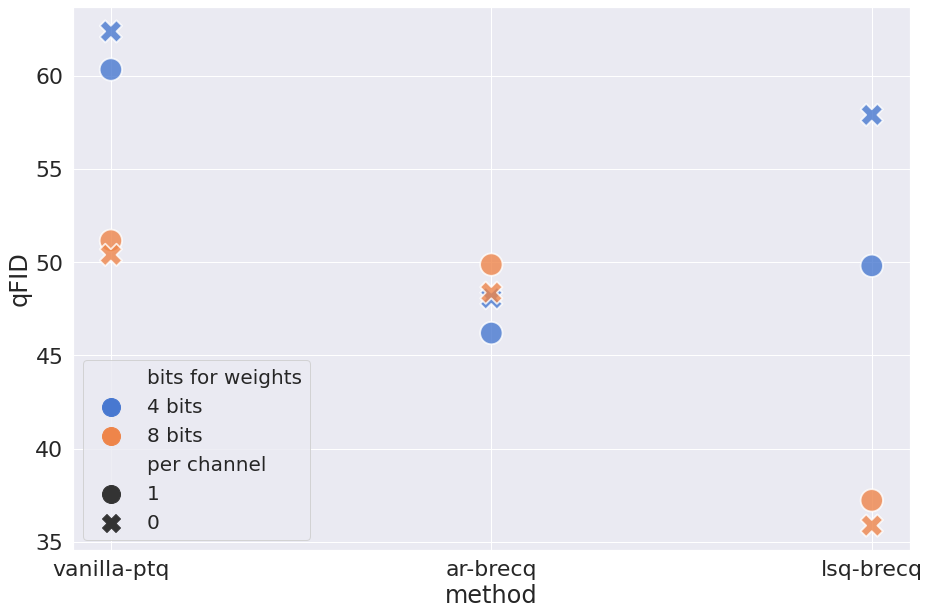

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=2)

plt.figure(figsize=(15, 10))
df["bits for weights"] = df["quant_bits"].apply(float).apply(int).apply(str) + ' bits'
df["per channel"] = df["per_channel"].apply(bool).apply(int).apply(str)

ax = sns.scatterplot(x="method", y="qFID", hue="bits for weights", style="per channel", data=df,
                     palette="muted", s=500, alpha=0.8)


lgnd = plt.legend(loc="best", numpoints=1, fontsize=20, markerscale=3)
plt.show()

In [8]:
import matplotlib.pyplot as plt
from torchvision import utils
from utils.ptq_utils import get_mean_style, sample
import torch

imgs = []
for method in ["full_precision", "vanilla-ptq","ar-brecq", "lsq-brecq"]:
    n_bits = 8
    per_channel = True
    
    q_params = {'q_max': 0.9999, 'q_min': 1 - 0.9999,
                'q_max_w': 0.9999, 'q_min_w': 1 - 0.9999,
                'bits_w': n_bits, "per_channel":per_channel,
                'lsq_act': "brecq" in method, 'lsq_weight': method=="lsq-brecq",
                'adaround': method=="ar-brecq"} 

    path = weights_path + f"/{method}_per_channel{per_channel}_n_bits{n_bits}.pth"
    fp_path = weights_path + "/fp_model.pth"

    generator = get_pretrained_model(path, fp_path, q_params,
                                     get_fp=(method=="full_precision")).cuda().eval()
    mean_style = get_mean_style(generator, "cuda")
    img = sample(generator, 6, "cuda", seed=3, mean_style=mean_style)
    imgs.append(img)

Calibrating...: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


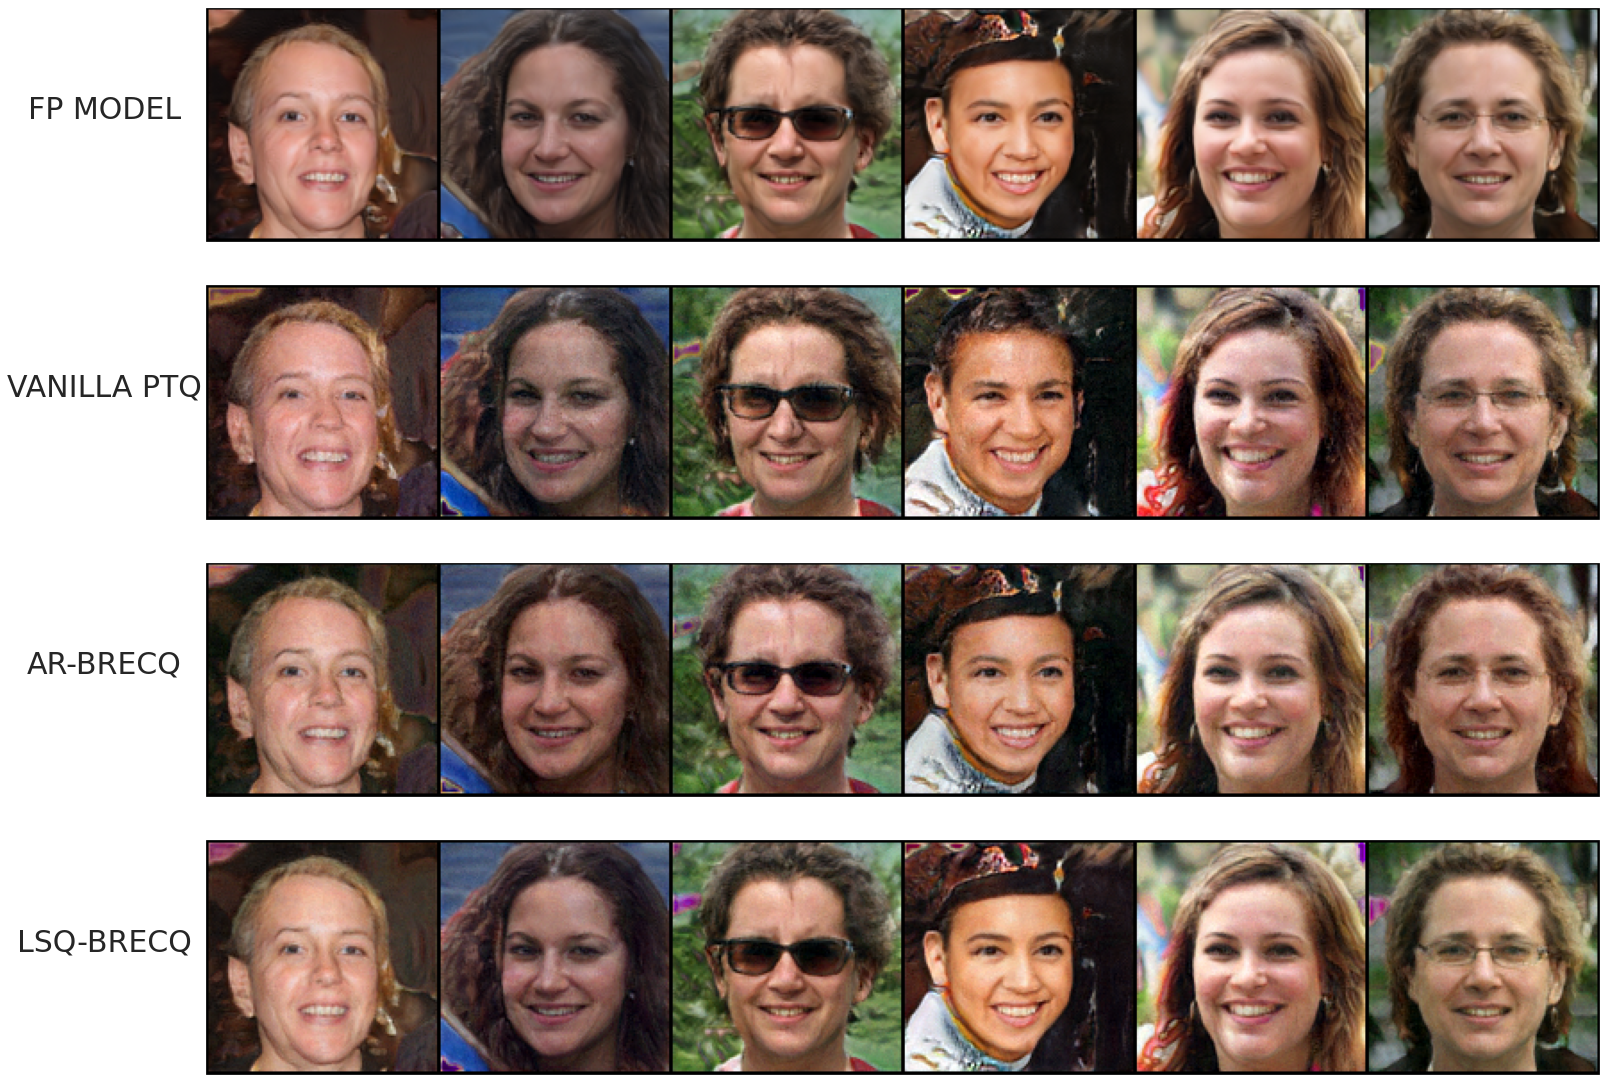

In [41]:
import matplotlib
plt.figure(figsize=(24, 16))

matplotlib.rcParams.update({'font.size': 30})

methods = ["FP MODEL", "VANILLA PTQ", "AR-BRECQ", "LSQ-BRECQ"]

for i, (method, img) in enumerate(zip(methods, imgs)):
    plt.subplot(4, 1, i + 1)
    plt.grid(False)
    grid = utils.make_grid(img, nrow=6, normalize=True, range=(-1, 1))
    plt.imshow(grid.T.movedim(0, 1).cpu().numpy())
    plt.ylabel(method, rotation=0, labelpad=100, fontsize=30)
    plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    
plt.tight_layout(pad=1.4, w_pad=300)
plt.savefig("images.jpg")